# Exploratory Data Analysis of Pi Hole DNS Request Logs

Dataset is sourced from the event based logging of Pi Hole. Data is stored in a SQLite database with a timestamp, client requestor, whether it was blocked, and the domain name.

## Objectives

 - Identify methods for data ingestion/cleansing/preparation.
 - Find statistical relationships that can be used to handrail online learning
 - Look at potential imablances between domain names (overrepresentation)



In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import blackmanharris

# Load Dataset from SQLite DB

In [1467]:
"""
Load Pi Hole logging data from SQLite database using sqlalchemy and pandas.
"""

db_connect = create_engine('sqlite:///pihole-FTL.db')
connection = db_connect.raw_connection()
df = pd.read_sql("SELECT * FROM queries", con=connection)
df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)
df['not_blocked'] = df.status.apply(lambda x: 1 if x in [2,3] else 0)

# Apply some data prep to timestamps

In [467]:
"""
Apply transformations to timestamps for aggregation
Operations performed:
    Get timestamps relative to initial timestamp
    Bin data into 100 sec (~1.7 min) bins
    Modulo 86400 for seconds elapsed
    Div 86400 for days elapsed
Initial day in dataset is roughly at midnight, so no 
offset in time required or pruning of dataset.
"""

agg_df = df.copy()
agg_df['timestamp'] = agg_df.timestamp.round(-2)
agg_df['timestamp'] -= agg_df.timestamp.min()
agg_df['not_blocked'] = agg_df.blocked.apply(lambda x: 1 if not x else 0)
agg_df['day'] = agg_df.timestamp.apply(lambda x: int(x / (60*60*24)))
agg_df['time_of_day'] = agg_df.timestamp.apply(lambda x: x % (60*60*24))

In [571]:
"""
Find number of unique subdomains and domains.
"""

print('Unique domains: ',df.domain.nunique())
print('Unique sub domains: ',len(np.concatenate(np.unique(df.domain.apply(lambda x: x.split('.')).values))))

Unique domains:  11527
Unique sub domains:  38424


[442518 128867]


Text(0, 0.5, '# of DNS Requests')

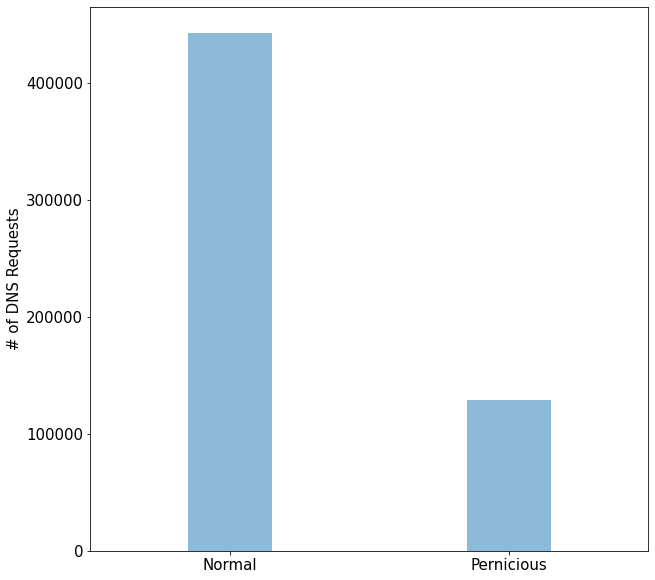

In [1013]:
labels, counts = np.unique(df.blocked.values, return_counts=True)
print(counts)
plt.figure(figsize=(10,10))
plt.bar(labels,counts,align='center',width=0.3,color='tab:blue',alpha=0.5)
plt.xticks([0,1],['Normal','Pernicious'],size=15)
plt.yticks(size=15)
plt.xlim(-0.5,1.5)
plt.ylabel('# of DNS Requests',size=15)

In [1211]:
import random
import youtokentome as yttm

"""
Import YouTokenToMe tokenization model. Use pre-trained model from
model exploration notebook.
"""


train_data_path = "domains.txt"
model_path = "./yttm_model/yttm_ads.model"

# Training model
if False:
    yttm.BPE.train(data=train_data_path, vocab_size=300, model=model_path)

# Loading model
bpe = yttm.BPE(model=model_path)

% of data affected by 30 token maxmimum:  2.0


Text(28, 40000, 'Max Zero Padded Input Vector Size')

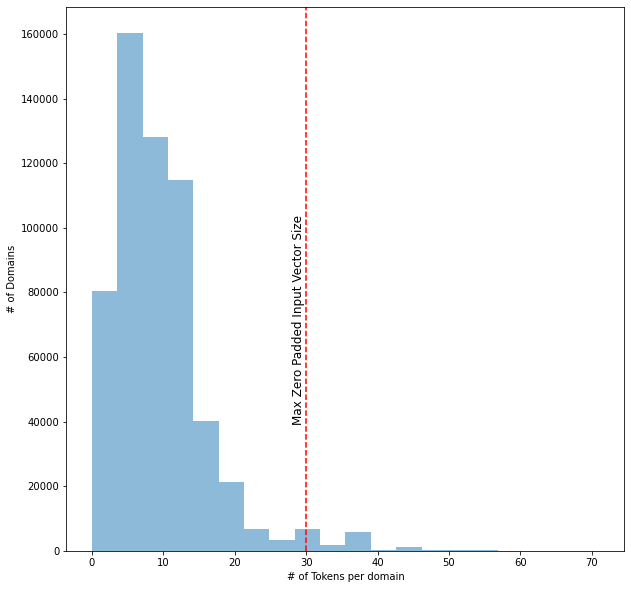

In [1275]:
#encoded_domains = list(map(lambda x: bpe.encode(x),df.domain.values))
#encoded_ct = [len(i) for i in encoded_domains]
print('% of data affected by 30 token maxmimum: ',np.round(100*np.sum(np.array(encoded_ct)>30)/len(encoded_ct),0))
plt.figure(figsize=(10,10))
plt.hist(encoded_ct,bins=20,alpha=0.5)
plt.ylabel('# of Domains')
plt.xlabel('# of Tokens per domain')
plt.axvline(30,ls='--',color='red')
plt.text(28,40000,'Max Zero Padded Input Vector Size',rotation=90,size=12)

[(396, 82), (588, 2)]


/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


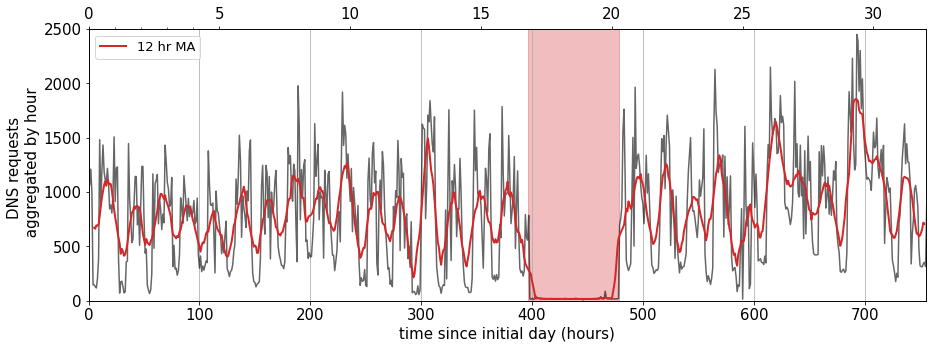

In [1686]:
from statsmodels.tsa.stattools import adfuller

def adjacent_fill(x):
    for i in range(int(len(x))):
        try:
            if sum(x[i:i+3]) == 3*x.max():
                x[i] = x.max()
            else:
                x[i] = 0.
        except:
            if sum(x[i:]) == len(x[i:])*x.max():
                x[i] = x.max()
            else:
                x[i] = 0.
    pairs = []
    contig = 0
    for j,xj in enumerate(x):
        if x[j] == x[np.min([j+1,len(x)-1])] and xj==0:
            contig += 1
            if contig == 1:
                init_j = j
        elif contig > 0:
            pairs.append((init_j,contig))
            contig = 0
    max_idx = np.argmax([i[1] for i in pairs])
    print(pairs)
    return x,pairs[max_idx]

by_hour = agg_df.copy()
by_day = agg_df.copy()
by_hour['timestamp'] = by_hour.timestamp // 3600
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(range(len(by_hour.groupby('timestamp').count().blocked)),by_hour.groupby('timestamp').count().blocked,
        color='black',alpha=0.6)
ax.plot(range(-6,len(by_hour.groupby('timestamp').count().blocked)-6),
        by_hour.groupby('timestamp').count().rolling(12).mean().blocked,lw=2,color='tab:red',label='12 hr MA')
plt.ylim(0,2500)
plt.xlim(0,755)
ax.set_ylabel('DNS requests \n aggregated by hour',size=15)
ax.set_xlabel('time since initial day (hours)',size=15)
x_mask,(bad_min,bad_max) = adjacent_fill(np.where(by_hour.groupby('timestamp').count().blocked < 50, 0, 2000))
ax.fill_betweenx([0,4000],bad_min,bad_min+bad_max,color='tab:red',alpha=0.3)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.legend(loc=2,prop={'size':13})
ax2 = ax.twiny()
ax2.set_xticks(range(5),[int(i) for i in np.linspace(0,by_hour.timestamp.max()/24.,33).round()])
ax2.tick_params(axis='x', labelsize=15)
#ax2.set_xlabel('days',size=15)
ax2.set_xlim(0,32)
ax.grid(axis='x')
plt.savefig('time_series.png')

In [1470]:
def mask_idx(min_x,max_x,len_x):
    idx = range(len_x)
    idx_left = idx[:min_x]
    idx_right = idx[min_x+max_x:]
    return np.append(idx_left,idx_right)

cleaned = by_hour.groupby('timestamp').count().blocked.iloc[mask_idx(bad_min,bad_max,by_hour.timestamp.nunique())]
print('Time series mean',cleaned.mean().round(2),'Time series std',cleaned.std().round(2))

Time series mean 837.22 Time series std 487.05


Text(0.5, 1.0, 'Aggregate requests within a day')

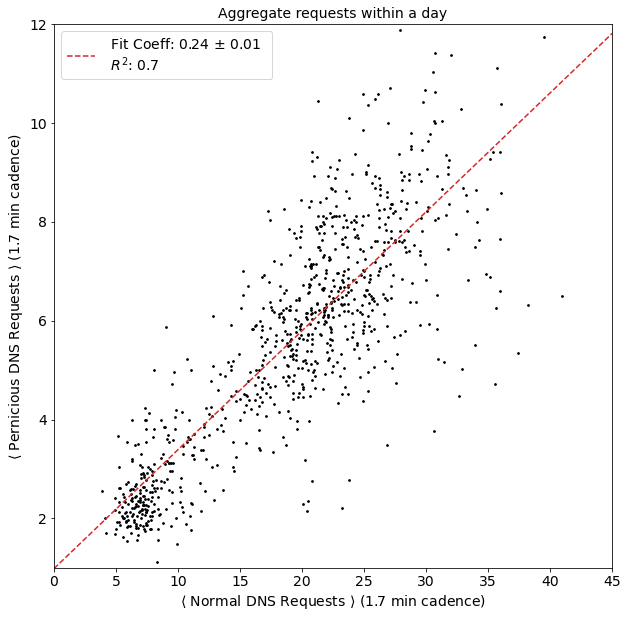

In [1471]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score
tod_counts = agg_df.groupby(['time_of_day','day']).sum().reset_index()#.not_blocked.values
tod_blocked_counts = agg_df.groupby(['time_of_day','day']).sum().reset_index()#.blocked.values
tod_counts = tod_counts.groupby('time_of_day').mean().not_blocked.values
tod_blocked_counts = tod_blocked_counts.groupby('time_of_day').mean().blocked.values

tod_counts = sm.add_constant(tod_counts.reshape(-1,1))

regression_model = sm.OLS(tod_blocked_counts.reshape(-1,1), tod_counts).fit()
#regression_model = LinearRegression().fit(tod_counts.reshape(-1,1),tod_blocked_counts.reshape(-1,1))

plt.figure(figsize=(10,10))
plt.scatter(tod_counts[:,1],tod_blocked_counts,s=3,color='black')
coeff = regression_model.params[1].round(2)
coeff_err = np.sqrt(regression_model.cov_params()[1][1]).round(2)
r2 = round(r2_score(tod_blocked_counts,regression_model.predict(tod_counts)),2)
plt.plot(np.linspace(0,50,1360),regression_model.predict(sm.add_constant(np.linspace(0,50,1360))),'--',
         label=' Fit Coeff: {0} $\pm$ {1}  \n $R^2$: {2}'.format(coeff,coeff_err,r2),color='tab:red')
plt.legend(fontsize=14)
plt.xlim(0,45)
plt.ylim(1,12)
plt.xlabel(r'$\langle$ Normal DNS Requests $\rangle$ (1.7 min cadence)',size=14)
plt.ylabel(r'$\langle$ Pernicious DNS Requests $\rangle$ (1.7 min cadence)',size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Aggregate requests within a day',size=14)
#plt.savefig('TimeOfDayRegression.png')

(array([-6., -4., -2.,  0.,  2.,  4.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

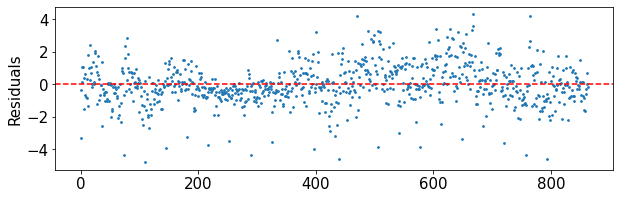

In [1472]:
"""
Look at the residuals of the fit.
"""
plt.figure(figsize=(10,3))
plt.scatter(range(len(tod_counts)),tod_blocked_counts-regression_model.predict(tod_counts),s=3)
plt.axhline(0,color='red',ls='--')
plt.ylabel('Residuals',size=15)
plt.xticks(size=15)
plt.yticks(size=15)

Text(0.5, 0, 'Domain Depth')

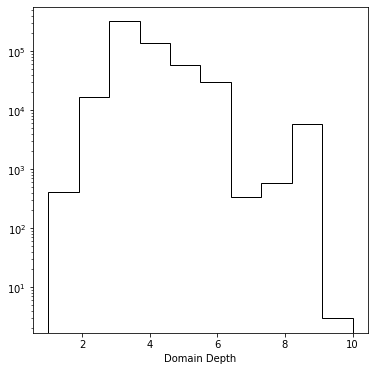

In [1265]:
plt.figure(figsize=(6,6))
plt.hist(df.domain.apply(lambda x: len(x.split('.'))).values,histtype='step',color='black')
plt.yscale('log')
plt.xlabel('Domain Depth')

In [1209]:
"""
Notes:
Run auto/cross correlations to pick out periodicities

""" 




'\nNotes:\nRun auto/cross correlations to pick out periodicities\n\n'

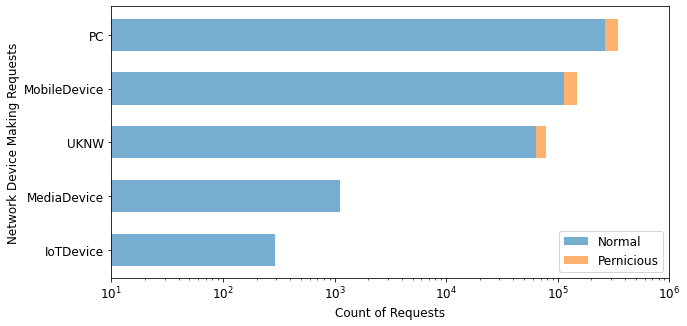

In [1133]:
"""
Look at the requests by type and by requesting device(client ip address).
"""
ip2name = {'192.168.0.112':'PC1','192.168.0.157':'IoTDevice1',
           '192.168.0.133':'IoTDevice3','192.168.0.192':'IoTDevice2',
          '192.168.0.161':'MobileDevice3','192.168.0.119':'PC2','192.168.0.129':'MobileDevice1',
          '192.168.0.121':'Raspberry Pi','192.168.0.155':'MediaDevice1','192.168.0.156':'PC3',
          '192.168.0.149':'MobileDevice2'}
#agg_df['client'] = agg_df.client.apply(lambda x: '192.168.0.120' if x=='127.0.0.1' else x)
agg_df['client_class'] = agg_df.client.apply(lambda x: ip2name.setdefault(x,'UKNWN')[:-1])
client_grp = agg_df.groupby('client_class').sum().reset_index()
total_sort = np.argsort(client_grp.blocked.values+client_grp.not_blocked.values)

plt.figure(figsize=(10,5))
plt.barh(np.arange(len(client_grp)),client_grp.not_blocked[total_sort],height=0.6,
         color='tab:blue',alpha=0.6,label='Normal')
plt.barh(np.arange(len(client_grp)),client_grp.blocked[total_sort],left=client_grp.not_blocked[total_sort],
         height=0.6,color='tab:orange',alpha=0.6,label='Pernicious')
plt.yticks(range(len(client_grp)),client_grp.client_class[total_sort],size=12)
plt.xticks(size=12)
#plt.text(10000,0.9,'{0}'.format(client_grp.not_blocked[total_sort].iloc[1]))
#plt.text(350,-0.1,'{0}'.format(client_grp.not_blocked[total_sort].iloc[0]),size=12)
plt.xscale('log')
plt.xlim(10**1,10**6)
plt.ylabel('Network Device Making Requests',size=12)
plt.xlabel('Count of Requests',size=12)
plt.legend(loc=0,prop={'size':12})
plt.savefig('NetworkDeviceAnalysis.png')

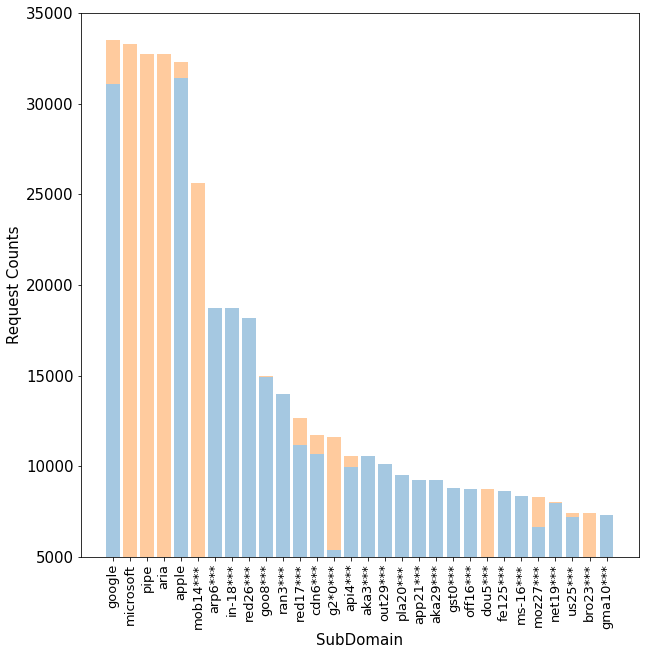

In [1507]:
"""
Look at domain subdomain frequencies.
Note: Look into how to prune random alphanumerics.

"""
from tqdm import tqdm
def word_freq(x):
    uni_x = np.unique(x)
    x = np.array(x)
    freqs_domains = [(np.sum(x==i),i) for i in tqdm(uni_x) if i not in ['com','net','org','edu','www']]
    freqs = [i[0] for i in freqs_domains]
    uni_x_ = [i[1] for i in freqs_domains]
    return freqs,uni_x_

def checknum(x):
    return any(i.isdigit() for i in x)

def redact(x):
    rnd_num = np.random.randint(30)
    return x[:3]+str(rnd_num)+'***'

def freqbyblocked(dframe,word,blocked=True):
    if blocked:
        freq = dframe.loc[dframe.domain.apply(lambda x: word in x.split('.'))].blocked.sum()
    else:
        freq = dframe.loc[dframe.domain.apply(lambda x: word in x.split('.'))].not_blocked.sum()
    return freq

#raw_subdomains = np.concatenate(df.domain.apply(lambda x: x.split('.')).values)
#raw_subdomains_nonum = [i for i in tqdm(raw_subdomains) if not checknum(i)]
#wfreq,word = word_freq(raw_subdomains_nonum)
#wsort = np.argsort(wfreq)[::-1]
#word_sorted = np.array(word)[wsort][:30]

#blocked_freq = list(map(lambda x: freqbyblocked(df,x),word_sorted))
#nonblocked_freq = list(map(lambda x: freqbyblocked(df,x,blocked=False),word_sorted))

wfreq_sorted = np.array(wfreq)[wsort][:30]
word_sorted = np.array([redact(word) if i > 4 else word for i,word in enumerate(word_sorted)])

plt.figure(figsize=(10,10))
#plt.bar(word_sorted,wfreq_sorted,alpha=0.4)

plt.bar(word_sorted,nonblocked_freq,alpha=0.4)
plt.bar(word_sorted,blocked_freq,alpha=0.4,bottom=nonblocked_freq)
plt.xticks(rotation=90,size=13)
plt.yticks(size=15)
plt.xlabel('SubDomain',size=15)
plt.ylabel('Request Counts',size=15)
plt.ylim(5000,35000)
plt.savefig('DomainDist.png')
#plt.yscale('log')

In [1513]:
df.domain.isin(['mobile.pipe.aria.microsoft.com']).sum()

25372

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 0, 'Frequency (1/hr)')

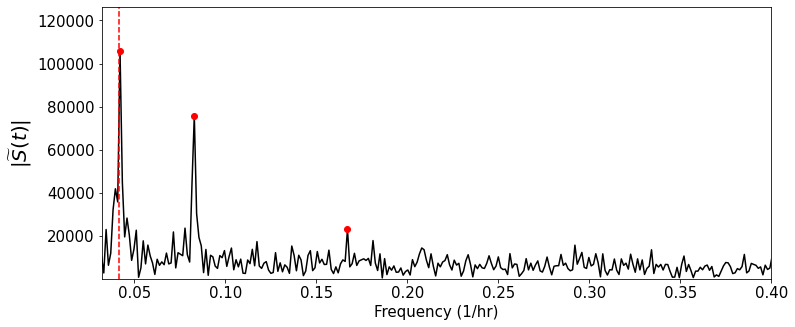

In [1754]:
fft_req_ct = np.abs(np.fft.fft(interp(by_hour.groupby('timestamp').count()).blocked.values))#by_hour.groupby('timestamp').count().blocked)))[::-1]

freqs = np.fft.fftfreq(len(fft_req_ct),d=1)[:int(len(fft_req_ct)/2)]
time = np.nan_to_num(1./freqs)[::-1]

plt.figure(figsize=(12,5))
plt.plot(freqs,fft_req_ct[:int(len(fft_req_ct)/2)],color='black')

peak_idx = find_peaks(fft_req_ct[:int(len(fft_req_ct)/2)],distance=30,prominence=20000)[0]

plt.plot(freqs[peak_idx],fft_req_ct[:int(len(fft_req_ct)/2)][peak_idx],'ro')
#plt.yscale('log')
plt.yticks(size=15)
plt.xticks(size=15)
plt.axvline(1./24,color='red',ls='--')
#plt.axvline(1./(14*24),color='red',ls='--')
#plt.axvline(1./12,color='red',ls='--')
#plt.axvline(1./6,color='red',ls='--')
#plt.axvline(1./3,color='red',ls='--')
plt.xlim(0.032,0.4)
plt.ylim(10**(2.5),2*10**(4.8))
plt.ylabel('$|\widetilde{S}(t)|$',size=20)
plt.xlabel('Frequency (1/hr)',size=15)
#plt.savefig('spectrum.png')

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


Text(0, 0.5, 'SNR')

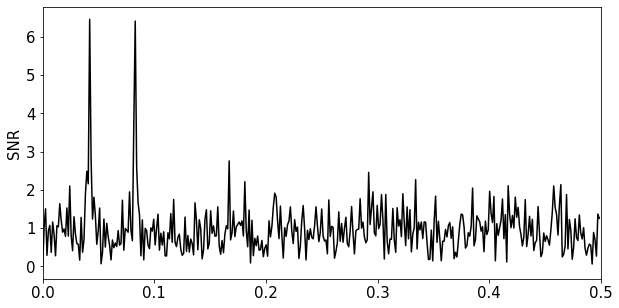

In [1876]:
"""
Look at spectral noise profile.
"""

from scipy.optimize import curve_fit
def spec_noise(x,alpha,C):
    return C*1./(x**alpha)

curve_fit(spec_noise,freqs[1:],fft_req_ct[:int(len(fft_req_ct)/2)][1:],p0=[1.,1.])
#ls = least_squares(spec_noise,x0=[1e5,0.5])
#ls.fit(fft_req_ct[:int(len(fft_req_ct)/2)])
plt.figure(figsize=(10,5))
plt.plot(freqs,fft_req_ct[:int(len(fft_req_ct)/2)]/((3.58*10**3)*(1./(freqs**0.48))),color='black')
#plt.plot(freqs,(3.58*10**3)*(1./(freqs**0.48)))
plt.xticks(size=15)
plt.yticks(size=15)
#plt.yscale('log')
#plt.ylim(10**3,10**6)
plt.xlim(0,0.5)
plt.ylabel('SNR',size=15)


In [1580]:
def interp(df):
    """
    Cheap interpolation attempt in a dataframe. Not valid for
    large gaps in the time-series.
    """
    df = df.sort_values(by='timestamp').reset_index()
    for i in range(df.timestamp.max()):
        if any(df.timestamp.isin([i])):
            continue
        elif i != df.timestamp.max()-1:
            #print(i)
            # Count of domains before and after
            x1 = df.iloc[i-1].blocked
            x2 = df.iloc[i+1].blocked
            interp_df = pd.DataFrame({'timestamp':[i],'domain':'XXXXX','blocked':[int(np.mean([x1,x2]))]})
            df_ = pd.concat([df,interp_df]).reset_index(drop=True)
            #df = pd.concat([df_,df.iloc[i+1:]]).reset_index(drop=True)
            df = df_.sort_values(by='timestamp').reset_index(drop=True)
            #print(df)
    return df

In [1782]:
def complexity(x):
    """
    Attempt to calculate a proxy for information content
    through the entropy of how unique the tokenization.
    May be better to try and calculate the Kolmogorov 
    Complexity upper limit instead.
    """
    x_uni,x_cts = np.unique(x,return_counts=True)
    #print(x_uni,x_cts)
    probs = x_cts/len(x)
    return -np.sum(probs*np.log(probs))
    
complexity([32,12,12,21,32]),
complexity(np.random.randint(0,32,size=10))

2.3025850929940455

## Look at distribution of "complexities" from tokenized domains

(array([1.37794e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 2.13800e+03,
        5.90050e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 6.41000e+02,
        4.76000e+02, 7.20550e+04, 0.00000e+00, 1.69000e+02, 9.07000e+02,
        8.82720e+04, 0.00000e+00, 1.70000e+01, 1.29890e+04, 4.99740e+04,
        2.70000e+02, 3.46550e+04, 5.60000e+01, 1.08700e+04, 2.52410e+04,
        6.70000e+03, 1.52890e+04, 9.48500e+03, 1.49700e+03, 7.76800e+03,
        5.56900e+03, 8.93700e+03, 1.68100e+03, 6.42200e+03, 3.08300e+03,
        5.53700e+03, 2.87000e+03, 1.50000e+02, 1.62000e+02, 4.10000e+02,
        1.81000e+02, 4.00000e+01, 5.70000e+01, 1.30000e+01, 4.00000e+00]),
 array([0.        , 0.06658404, 0.13316808, 0.19975212, 0.26633616,
        0.3329202 , 0.39950425, 0.46608829, 0.53267233, 0.59925637,
        0.66584041, 0.73242445, 0.79900849, 0.86559253, 0.93217657,
        0.99876061, 1.06534466, 1.1319287 , 1.19851274, 1.265096

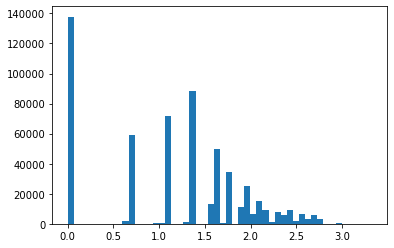

In [1824]:
encoded_hosts = list(map(lambda x: bpe.encode(x),df.domain.apply(lambda x: x.split('.')[0]).values))
complexities = list(map(complexity,encoded_hosts))
dlen = list(map(len,encoded_hosts))
plt.hist(complexities,bins=50)

## TFIDF analysis of most frequent n-grams for blocked content

In [2]:
import functions as fn
grav_domains = fn.load_gravity(dir='').domain.values
grav_df = pd.DataFrame({'domain':grav_domains,'blocked':np.ones(len(grav_domains))})

In [3]:
domains_unique = grav_df.domain.apply(lambda x: ' '.join(x.split('.'))).unique()

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = ['com','net','org','edu','arpa','in']
vectorizer = TfidfVectorizer(stop_words=stop_words,ngram_range=(2,2),max_features=500).fit(domains_unique)

In [25]:
docs = vectorizer.transform(domains_unique).toarray()

In [35]:
#np.mean(docs,axis=0)
np.array(vectorizer.get_feature_names())[np.argsort(np.mean(docs,axis=0))[::-1]]

array(['112 2o7', 'co uk', 'us intellitxt', 'ero advertising', '122 2o7',
       'beget tech', 'co za', 'p2l info', 'tmweb ru', 'gemius pl',
       'oewabox at', 'hit gemius', 'safety microsoft', 'tt omtrdc',
       'admicro vn', 'cba pl', 'track msadcenter', 'co id', 'is best',
       'co jp', 'ddns name', 'esy es', 'myjino ru', 'littlematchagirl au',
       'api swrve', 'uk intellitxt', 'sc omtrdc', 'adtech de', 'co pl',
       'content swrve', 'adocean pl', 'adtech us', 'adtech fr',
       'stats esomniture', 'safety apple', 'co kr', 'us east', '24 eu',
       'ad jp', 'engine mobileapptracking', 'x9 eu', 'madpendesign au',
       'maherstcottage au', 's3 amazonaws', 'ne jp', 'gmtdmp mookie1',
       'co nz', 'co ke', 'you2 pl', 'usa cc', 'hol es', 'eby de',
       'signin eby', 'eclick vn', 'civpro co', 'petrovka info',
       'popunder ru', 'free fr', 'co il', 'iad 03', 'bradul creatory',
       'pe hu', '5v pl', '03 braze', 'adflex vn', 'extreme dm',
       'ingest crittercism', 

In [40]:
grav_df.loc[grav_df.domain.apply(lambda x: 'ero' in x and 'advertising' in x)]

,domain,blocked
468,data-ero-advertising.com,1.0
469,www.data-ero-advertising.com,1.0
612,0latfee.ero-advertising.com,1.0
613,www.0latfee.ero-advertising.com,1.0
614,2baners.ero-advertising.com,1.0
...,...,...
34727,pops.ero-advertising.com,1.0
35196,advertising.embarcaderopublishing.com,1.0
44703,data-failover.eroadvertising.com,1.0
44704,data.eroadvertising.com,1.0
